In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.lines import Line2D
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from typing import Mapping
from typing import TypeAlias
from typing import NamedTuple
from typing import Iterable
from typing import Sequence

PATH_TO_PROJECT = 'C:\\Users\\Mark\\PycharmProjects\\machineLearningNstu'
sys.path.append(PATH_TO_PROJECT)

# Получение исходных данных

In [2]:
def _additive_check(additive_name: str) -> ValueError | None:
    if additive_name not in ['air', 'steam']:
        raise ValueError('Неверное имя для вводимого компонента! [steam или air]')
        

In [3]:
FuelCombination: TypeAlias = str

def get_all_combination_with(additive_name: str) -> Iterable[FuelCombination]:
    _additive_check(additive_name)
    fuel_list = ['diesel', 'kerosene', 'heavy_oil', 'crude_oil', 'waste_oil']
        
    return [fuel + '_' + additive_name for fuel in fuel_list]
    

In [4]:
Paths: TypeAlias = str

def get_paths_to_csv(path_to_project: str, additive_name: str) -> Sequence[Paths]:
    combs = get_all_combination_with(additive_name)
    path_to_raw = os.path.join(PATH_TO_PROJECT, 'data', 'raw')

    return [os.path.join(path_to_raw, comb + '.csv') for comb in combs]
        

In [5]:
def get_approx_data(additive_name: str) -> Mapping[FuelCombination, pd.DataFrame]:
    paths = get_paths_to_csv(PATH_TO_PROJECT, additive_name)
    combs = get_all_combination_with(additive_name)
    approx_data = {}
    
    for i, comb in enumerate(combs):
        approx_data[comb] = pd.read_csv(paths[i])
    return approx_data
        

# Получение тестовой и обучающей выборки

In [6]:
Component: TypeAlias = str

def _columns_count_check(columns_to_compare: Iterable[Component]) -> ValueError | None:
    if len(columns_to_compare) > 3 or len(columns_to_compare) < 2:
        raise ValueError('Необходимо сравнивать 2/3 столбца!')
        

In [7]:
def _clean_name_from_additive(fuel_comb: str) -> str:
    if '_steam' in fuel_comb:
        result = fuel_comb.replace('_steam', '')
    else:
        result = fuel_comb.replace('_air', '')  
    return result


In [8]:
def _columns_exist_check(df: pd.DataFrame, columns: Sequence[Component]) -> ValueError | None:
    for col in columns:
        if col not in df.columns and col != 'alpha':
            raise ValueError(f'Столбец ({col}) указан неверно или не существует в данном DataFrame!')
        

In [9]:
def _alpha_check(columns: Sequence[Component]) -> ValueError | None:
    if 'alpha' in columns and columns[0] != 'alpha':
        raise ValueError('Cтолбец alpha должен идти на первом месте!')
        

In [10]:
SampleData: TypeAlias = pd.DataFrame

def get_sample_data(
    additive_name: str, 
    columns_to_compare: Sequence[Component]
) -> SampleData:
    _columns_count_check(columns_to_compare)
    _alpha_check(columns_to_compare)
    
    approx_data = get_approx_data(additive_name)
    samples = []

    for name in approx_data:
        df = approx_data[name]
        _columns_exist_check(df, columns_to_compare)
        
        if columns_to_compare[0] == 'alpha':
            alpha = 21 / (21 - df['O2'])
            sample = df[columns_to_compare[1:]].copy()
            sample.loc[:, 'alpha'] = alpha
        else:
            sample = df[columns_to_compare].copy()
        
        sample.loc[:, 'fuel_type'] = _clean_name_from_additive(name)
        samples.append(sample)

    res_df = pd.concat([*samples], axis=0)
    return res_df


In [11]:
TrainData: TypeAlias = pd.DataFrame

def get_train_sample(df: SampleData, train_sample_procent: float) -> TrainData:
    if train_sample_procent > 1:
        raise ValueError('Должны быть указаны десятые доли процента!')
    training_sample_size = int(len(df) * train_sample_procent)
    return df.sample(training_sample_size)
    

# График обучающей выборки (3-ex мерное пространство)

In [12]:
def _check_2d_plot_columns(columns_to_compare: Sequence[Component]):
    if len(columns_to_compare) > 2:
        raise ValueError('Количество колонок у 2d графика должно быть 2!')
        

In [13]:
def show_cluster_plot(
    additive_name: str,
    columns_to_compare: Sequence[Component],
    train_sample_procent: float
) -> None:
    _check_2d_plot_columns(columns_to_compare)
        
    df = get_train_sample(get_sample_data(additive_name, columns_to_compare), train_sample_procent)
    
    sns.scatterplot(data=df, x=columns_to_compare[0], y=columns_to_compare[1], hue='fuel_type', edgecolor=None)
    plt.title(additive_name)
    

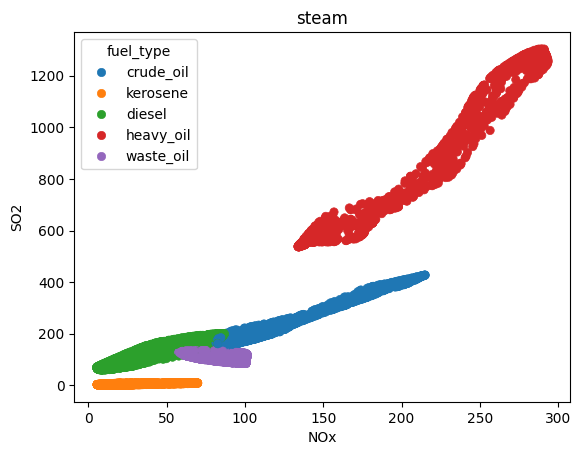

In [14]:
show_cluster_plot('steam', ['NOx', 'SO2'], 0.1)

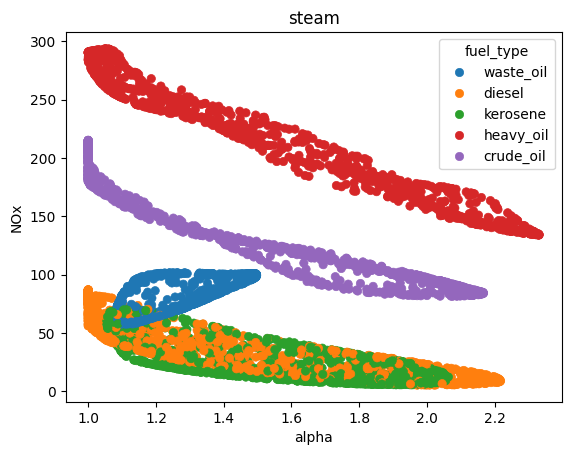

In [15]:
show_cluster_plot('steam', ['alpha', 'NOx'], 0.1)

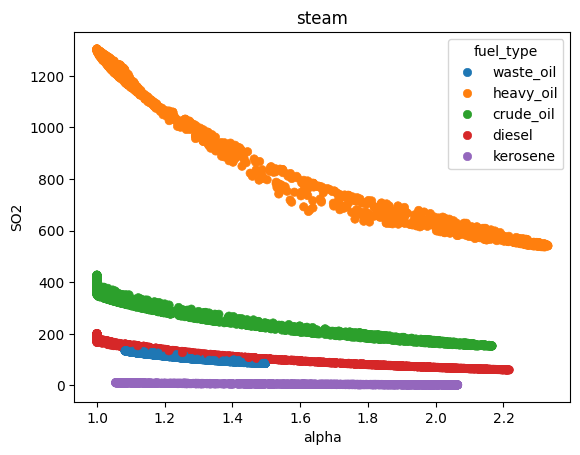

In [16]:
show_cluster_plot('steam', ['alpha', 'SO2'], 0.1)

# График обучающей выборки 4-ех мерное пространство

In [17]:
def _check_3d_plot_columns(columns_to_compare: Sequence[Component]):
    if len(columns_to_compare) != 3:
        raise ValueError('Количество колонок у 3d графика должно быть 3!')
        

In [18]:
def show_cluster_3d_plot(
    additive_name: str,
    columns_to_compare: Sequence[Component],
    train_sample_procent: float
) -> None:
    _check_3d_plot_columns(columns_to_compare)
    df = get_train_sample(get_sample_data(additive_name, columns_to_compare), train_sample_procent)

    categories = df['fuel_type'].copy()

    colors = {
    'heavy_oil': 'red',
    'kerosene': 'blue',
    'crude_oil': 'green',
    'waste_oil': 'yellow',
    'diesel': 'purple'
    }
    category_colors = np.array([colors[category] for category in categories])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(
        df[columns_to_compare[0]], 
        df[columns_to_compare[1]], 
        df[columns_to_compare[2]], 
        c=category_colors, 
        marker='o',
    )
    plt.title(additive_name)
    ax.set_xlabel(columns_to_compare[0])
    ax.set_ylabel(columns_to_compare[1])
    ax.set_zlabel(columns_to_compare[2])
    handles = [plt.Line2D([], [], marker='o', markersize=10, color=color, linestyle='None') for color in colors.values()]
    labels = list(colors.keys())
    plt.legend(handles, labels)
    

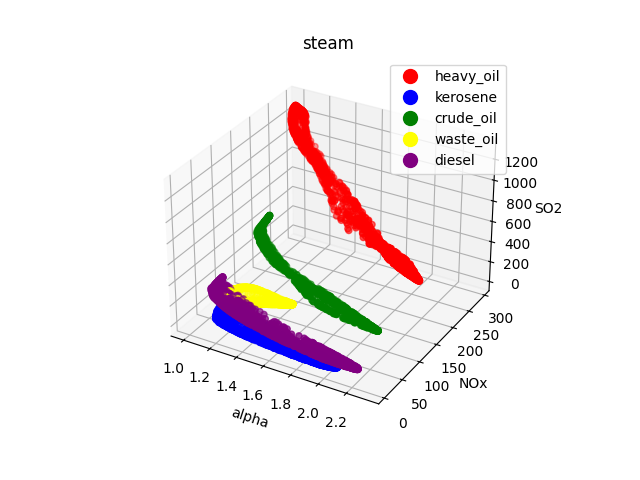

In [19]:
%matplotlib widget
show_cluster_3d_plot('steam', ['alpha', 'NOx', 'SO2'], 0.1)

# Сравнение эффективности предсказания в различных признаковых пространствах

In [39]:


def get_model_accuracy(
    additive_name: str,
    columns_to_compare: Sequence[Component],
    train_sample_procent: float
) -> None:
    sample = get_sample_data(additive_name, columns_to_compare)
    X_test, X_train, y_test, y_train = train_test_split(
        sample[columns_to_compare], 
        sample['fuel_type'], 
        test_size=train_sample_procent, 
        random_state=42
    )
    
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Точность прогнозирования:", np.round(accuracy, 4))
    

In [40]:
get_model_accuracy('steam', ['NOx', 'SO2'], 0.1)

Точность прогнозирования: 0.9829


In [41]:
get_model_accuracy('steam', ['alpha', 'NOx'], 0.1)

Точность прогнозирования: 0.7822


In [42]:
get_model_accuracy('steam', ['alpha', 'SO2'], 0.1)

Точность прогнозирования: 0.9995


In [43]:
get_model_accuracy('steam', ['alpha', 'NOx', 'SO2'], 0.1)

Точность прогнозирования: 0.9954


# Изображение разделяющей гиперплоскости в различных признаковых пространствах

In [62]:
def show_decision_bounds_2d(
    additive_name: str,
    columns_to_compare: Sequence[Component],
    train_sample_procent: float
) -> None:
    sample = get_sample_data(additive_name, columns_to_compare)
    X_test, X_train, y_test, y_train = train_test_split(
        sample[columns_to_compare], 
        sample['fuel_type'], 
        test_size=train_sample_procent, 
        random_state=42
    )
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train)
    
    fig, ax = plt.subplots()
    sns.scatterplot(data=sample, x=columns_to_compare[0], y=columns_to_compare[1], hue='fuel_type', edgecolor=None)
    DecisionBoundaryDisplay.from_estimator(
        svm,
        X_test,
        ax=ax,
        grid_resolution=200,
        plot_method="contour",
        colors="black",
        alpha=0.3,
    )
    plt.title(additive_name)
    
    

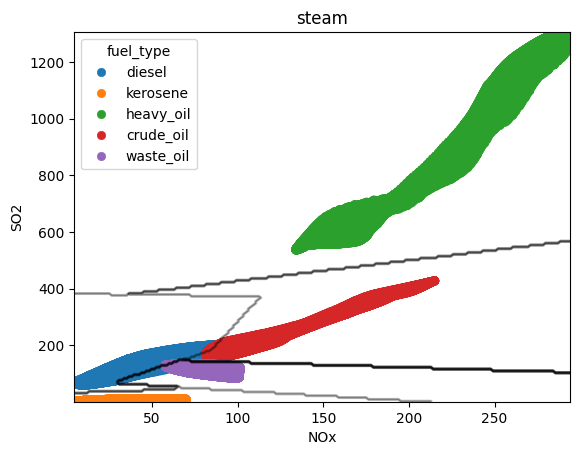

In [63]:
show_decision_bounds_2d('steam', ['NOx', 'SO2'], 0.1)

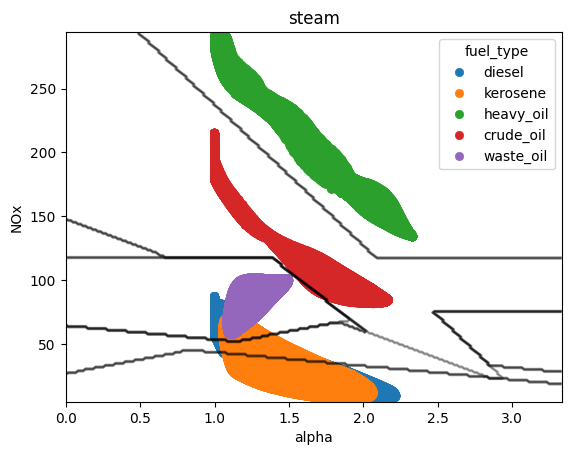

In [64]:
show_decision_bounds_2d('steam', ['alpha', 'NOx'], 0.1)

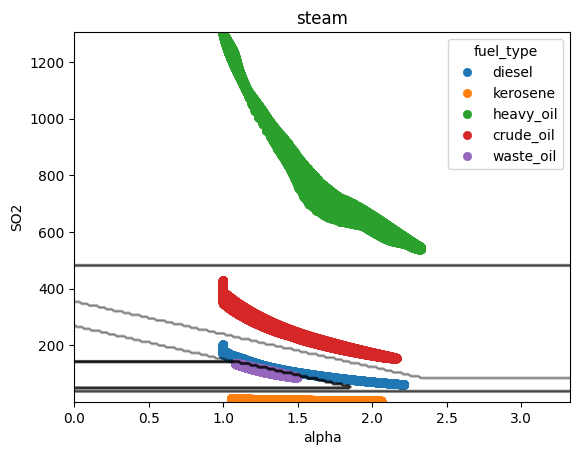

In [65]:
show_decision_bounds_2d('steam', ['alpha', 'SO2'], 0.1)